[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1rsFeNH-ldl3-UCjRoEMUtuxPekRjTEgu?usp=sharing)

In [1]:
from google.colab import drive #구글드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [138]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob
from tensorflow.keras.layers import Reshape

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [137]:
load_y=np.load('./drive/MyDrive/dataset_40000.npz')  #이미지 데이터가 저장된 NPZ 로드하기.
Y_1 = load_y['arr_0']
load_y.close()
Y_1 = Y_1[:-1000]    
Y_test = Y_1[-1000:]
del load_y
gc.collect()

44652

데이터 전처리용 코드 (전처리 완료 후, 삭제 예정)

In [ ]:
!pip install pyturbojpeg  

from turbojpeg import TurboJPEG
jpeg = TurboJPEG()

train_y = []
train_test = []

for _ in range(40001,len(imgs)):
  if _%20000 == 0:
    print("{} / 100000".format(_))
  print(_)
  in_file = open(imgs[_], 'rb')
  img = jpeg.decode(in_file.read(),0)
  in_file.close()
  train_y.append(img.astype("float32")/255.0)

  if _ == 80000:
    Y_2 = np.array(train_y)
    Y = np.vstack((Y_1,Y_2))

    del Y_1
    del Y_2
    np.savez_compressed(f'./drive/MyDrive/dataset_{_}', Y)

print(Y.shape)


In [152]:
#팀장 데이터 불러오기 (Pre-Trained Model에 추가학습용) -> 동영상 프레임 추출 사진
minsu = glob.glob('./drive/MyDrive/videoimage3/*.png')
test_minsu = []
for _ in range(0,1000):
  img = cv2.imread(minsu[int(_*1.5)])
  img = cv2.resize(img,(128,128))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_minsu.append(img.astype("float32")/255.0)
  
test_minsu = np.array(test_minsu)

print(test_minsu.shape)

(1000, 128, 128, 3)


In [149]:
#실제 합성된 사진 테스트용 코드
real_test = glob.glob('./*.png')
real = []
img=cv2.imread(real_test[0])
img = cv2.resize(img,(128,128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
real.append(img.astype("float32")/255.0)


img=cv2.imread(real_test[1])
img = cv2.resize(img,(128,128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
real.append(img.astype("float32")/255.0)
  
real = np.array(real)

print(real.shape)

(2, 128, 128, 3)


In [139]:
# 오토인코더 모델 정의
def Autoencoder():

  X = tf.keras.layers.Input(shape=[128,128,3])

  #Encoder (Convolution layer 4겹)
  H = tf.keras.layers.Conv2D(32,(4,4),(2,2),activation='relu',padding='same')(X)
  H = tf.keras.layers.Conv2D(32*2,(4,4), (2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*4, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*8, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*16, (4,4),(2,2),activation='relu',padding='same')(H)

  pool_tmp = H.shape.as_list()
  pool_tmp=pool_tmp[1:]
  
  #Fully-Connected
  H = tf.keras.layers.Flatten()(H)
  flatten_tmp=H.shape.as_list()
  flatten_tmp=flatten_tmp[1]
 
  H = tf.keras.layers.Dense(4000,activation='swish')(H)
  H = tf.keras.layers.Dense(flatten_tmp,activation='swish')(H)
  H = Reshape(pool_tmp)(H)


  #Decoder
  H = tf.keras.layers.Conv2DTranspose(32*8,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*4,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*2,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(3,(2,2),strides=(2,2),padding='same',activation='relu')(H)

  model = tf.keras.models.Model(X,H)
  model.compile(optimizer='adam',loss='mean_squared_logarithmic_error', metrics=['acc']) #MSLE Loss Funciton 적용

  return model

ae_model = Autoencoder()
ae_model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 64, 32)        1568      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 32, 32, 64)        32832     
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 16, 16, 128)       131200    
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 4, 4, 512)         2097664   
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0  

In [142]:
#모델 체크포인트 설정
checkpoint_path = 'checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = True,
                                                monitor='val_acc',
                                                verbose=1)

In [143]:
# 오토인코더 모델 학습
history = ae_model.fit(Y_1,
                      Y_1,
                       batch_size=100, #한번에 학습할 데이터 Batch_size
                       epochs=50,      #에포크 설정
                       verbose=1,      #학습과정 시각화
                       shuffle=True,   #학습 데이터 셔플
                       callbacks=[checkpoint],  #모델 체크포인트 저장
                       validation_split=0.2)    #Validation_data는 20%


                      


Epoch 1/50
312/312 [==============================] - 21s 66ms/step - loss: 0.0019 - acc: 0.7348 - val_loss: 0.0020 - val_acc: 0.7062

Epoch 00001: val_acc improved from -inf to 0.70620, saving model to checkpoint.ckpt
Epoch 2/50
312/312 [==============================] - 21s 67ms/step - loss: 0.0018 - acc: 0.7509 - val_loss: 0.0019 - val_acc: 0.7256

Epoch 00002: val_acc improved from 0.70620 to 0.72556, saving model to checkpoint.ckpt
Epoch 3/50
312/312 [==============================] - 21s 67ms/step - loss: 0.0017 - acc: 0.7635 - val_loss: 0.0018 - val_acc: 0.7060

Epoch 00003: val_acc did not improve from 0.72556
Epoch 4/50
312/312 [==============================] - 21s 67ms/step - loss: 0.0016 - acc: 0.7762 - val_loss: 0.0017 - val_acc: 0.7305

Epoch 00004: val_acc improved from 0.72556 to 0.73053, saving model to checkpoint.ckpt
Epoch 5/50
312/312 [==============================] - 21s 67ms/step - loss: 0.0015 - acc: 0.7870 - val_loss: 0.0017 - val_acc: 0.7415

Epoch 00005: val_

In [ ]:
ae_images = ae_model.predict(test_minsu) #전이학습 평가
ae_images.shape

(1000, 128, 128, 3)

In [150]:
ae_images = ae_model.predict(real)  #최종 목표 합성물 평가
ae_images.shape

(2, 128, 128, 3)

In [153]:
ae_images = ae_model.predict(Y_test)  #Pre-trained Model 평가용
ae_images.shape

(1000, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


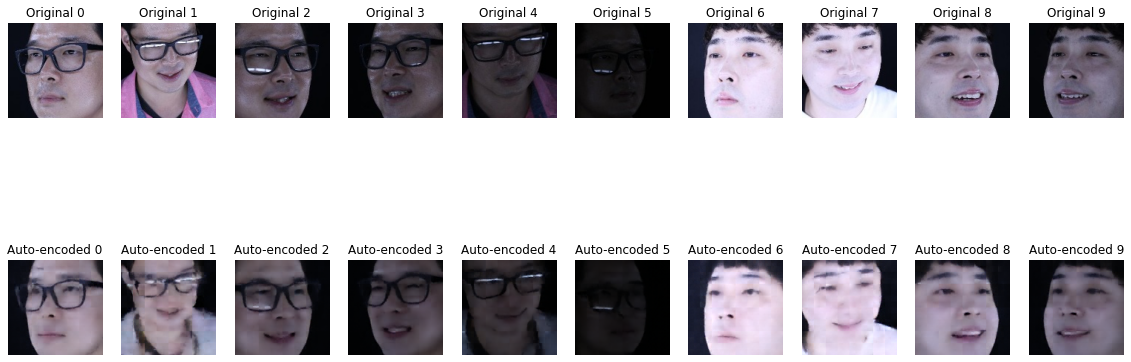

In [154]:
#이미지 출력
num = 10 
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(Y_test[i*20])
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(ae_images[i*20])
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()

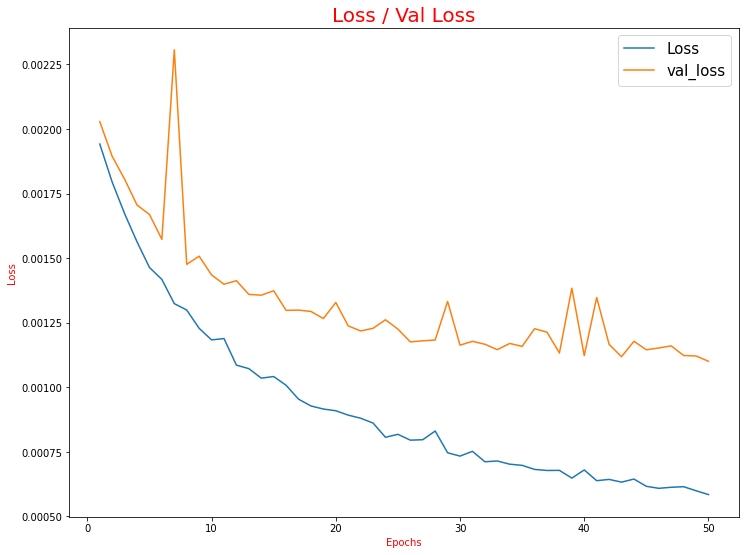

In [145]:
plt.figure(figsize=(12,9))
plt.plot(np.arange(1,51), history.history['loss'])
plt.plot(np.arange(1,51), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20, color='red')
plt.xlabel('Epochs', color='red')
plt.ylabel('Loss',color='red')
plt.legend(['Loss', 'val_loss'], fontsize=15)
plt.show()